In [2]:
# !pip install keras-vggface
# !pip install Keras-Applications

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Tue Dec 24 02:05:05 2019

@author: User
"""

def append_ext(fn):
    return fn+".jpg"

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Sat Dec 21 02:29:44 2019b
File: data_downloading.py
Author: Travis Tang (Voon Hao)
Github: https://github.com/travistangvh
Description: Downloading the FER2013 dataset
Note: This code is heavily adapted from Amine Horseman's the 'Convert FER2013 to Image and Landmarks' in the Facial Expression Recognition SVM git. 
(From: https://github.com/amineHorseman/facial-expression-recognition-svm/blob/master/convert_fer2013_to_images_and_landmarks.py)
"""

import numpy as np
import pandas as pd
import os
import errno
import imageio

# initialization
image_height = 48
image_width = 48
window_size = 24
window_step = 6
SAVE_IMAGES = True
SELECTED_LABELS = [0,1,2,3,4,5,6]
IMAGES_PER_LABEL = 500
OUTPUT_FOLDER_NAME = "/Users/lin-chuntseng/Desktop/emotion-detection-in-real-time/datasets/"

def data_download():
    # loading Dlib predictor and preparing arrays:
    print( "preparing")
    #predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    original_labels = [0, 1, 2, 3, 4, 5, 6]
    new_labels = list(set(original_labels) & set(SELECTED_LABELS))
    nb_images_per_label = list(np.zeros(len(new_labels), 'uint8'))
    try:
        os.makedirs(OUTPUT_FOLDER_NAME)
    except OSError as e:
        if e.errno == errno.EEXIST and os.path.isdir(OUTPUT_FOLDER_NAME):
            pass
        else:
            raise
            
    
    print( "importing csv file")
    
    data = pd.read_csv('/Users/lin-chuntseng/Desktop/emotion-detection-in-real-time/datasets/raw/fer2013.csv')
    
    for category in data['Usage'].unique():
        print( "converting set: " + category + "...")
        # create folder
        if not os.path.exists(category):
            try:
                os.makedirs(OUTPUT_FOLDER_NAME + '/' + category)
            except OSError as e:
                if e.errno == errno.EEXIST and os.path.isdir(OUTPUT_FOLDER_NAME):
                   pass
                else:
                    raise
        
        # get samples and labels of the actual category
        category_data = data[data['Usage'] == category]
        samples = category_data['pixels'].values
        labels = category_data['emotion'].values
        
        # get images and extract features
        images = []
        labels_list = []
        landmarks = []
        hog_features = []
        hog_images = []
        for i in range(len(samples)):
            try:
                if labels[i] in SELECTED_LABELS: 
                    image = np.fromstring(samples[i], dtype=int, sep=" ").astype(np.uint8).reshape((image_height, image_width))
                    images.append(image)
                    imageio.imwrite(OUTPUT_FOLDER_NAME + '/' + category + '/' + str(i) + '.jpg', image)
                    
            except Exception as e:
                print( "error in image: " + str(i) + " - " + str(e))
    
        np.save(OUTPUT_FOLDER_NAME + '/' + category + '/images.npy', images)


In [5]:
# -*- coding: utf-8 -*-
"""
Created on Sat Dec 21 02:29:44 2019
File: data_generator.py
Author: Travis Tang (Voon Hao)
Github: https://github.com/travistangvh
Description: Preprocessing data (into dataframe) for the training of the keras model
Note: A tutorial on the flow_from_dataframe method can be found at https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
"""

from tensorflow.keras.preprocessing.image import ImageDataGenerator

def data_generator(train_dir, valid_dir, test_dir, train_label, valid_label, test_label):
    # Add our data-augmentation parameters to ImageDataGenerator
    train_datagen = ImageDataGenerator(#rescale = 1./255.,
                                       rotation_range = 40,
                                       width_shift_range = 0.2,
                                       height_shift_range = 0.2,
                                       shear_range = 0.2,
                                       zoom_range = 0.2,
                                       horizontal_flip = True)
    
    # Note that the validation data should not be augmented!
    valid_datagen = ImageDataGenerator()#rescale = 1./255. )
    test_datagen = ImageDataGenerator()#rescale = 1./255. )
    
    # Flow training images in batches of 5 using train_datagen generator
    train_generator=train_datagen.flow_from_dataframe(dataframe=train_label,
                                                     directory=train_dir,
                                                     x_col="id",
                                                     y_col="emotion",
                                                     target_size=(96,96),
                                                     batch_size=32,
                                                     seed=42,
                                                     shuffle=True,
                                                     class_mode="categorical",
                                                     color_mode='rgb')
    
    # # Flow validation images in batches of 5 using test_datagen generator
    valid_generator=valid_datagen.flow_from_dataframe(dataframe=valid_label,
                                                      directory=valid_dir,
                                                      x_col="id",
                                                      y_col="emotion",
                                                      target_size=(96,96),
                                                      batch_size=32,
                                                      seed=42,
                                                      shuffle=True,
                                                      class_mode="categorical",
                                                      color_mode='rgb')
    
    # Flow validation images in batches of 5 using test_datagen generator
    test_generator=test_datagen.flow_from_dataframe(dataframe=test_label,
                                                     directory=test_dir,
                                                     x_col="id",
                                                     y_col=None,
                                                     target_size=(96,96),
                                                     batch_size=32,
                                                     seed=42,
                                                     shuffle=False,
                                                     class_mode=None,
                                                     color_mode='rgb')
    return train_generator, valid_generator, test_generator


In [6]:
# -*- coding: utf-8 -*-
"""
Created on Tue Dec 24 02:10:55 2019

@author: User
"""
import pandas as pd
#from src import append_ext

def label_and_dir():
 
    train_label = pd.read_csv('/Users/lin-chuntseng/Desktop/emotion-detection-in-real-time/datasets/labels/traininglabel.csv',dtype=str)
    valid_label = pd.read_csv('/Users/lin-chuntseng/Desktop/emotion-detection-in-real-time/datasets/labels/publictestlabel.csv',dtype=str)
    test_label = pd.read_csv('/Users/lin-chuntseng/Desktop/emotion-detection-in-real-time/datasets/labels/privatetestlabel.csv',dtype=str)
    
    train_label["id"]=train_label["id"].apply(append_ext)
    valid_label["id"]=valid_label["id"].apply(append_ext)
    test_label["id"]=test_label["id"].apply(append_ext)
    
    # Define our example directories and files
    train_dir = '/Users/lin-chuntseng/Desktop/emotion-detection-in-real-time/datasets/Training'
    valid_dir = '/Users/lin-chuntseng/Desktop/emotion-detection-in-real-time/datasets/PublicTest'
    test_dir = '/Users/lin-chuntseng/Desktop/emotion-detection-in-real-time/datasets/PrivateTest'
    return train_dir, valid_dir, test_dir, train_label, valid_label, test_label

In [11]:
# -*- coding: utf-8 -*-
"""
Created on Sat Dec 21 02:29:44 2019
File: training_emotion_classifier.py
Author: Travis Tang (Voon Hao)
Github: https://github.com/travistangvh
Description: Training of CNN model for emotion classification
Note: The following code is adapted from Machine Learning Mastery in the link https://machinelearningmastery.com/check-point-deep-learning-models-keras/
"""
from keras import applications
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
#from tensorflow.keras.applications.vggface import VGGFace
from keras_vggface.vggface import VGGFace
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
# from src import label_and_dir
# from src import data_generator
# from src import data_downloading

#downloading data from Kaggle

#data_download()

#importing data

train_dir, valid_dir, test_dir, train_label, valid_label, test_label = label_and_dir()
train_generator, valid_generator, test_generator = data_generator(train_dir, valid_dir, test_dir, train_label, valid_label, test_label)

#custom parameters
nb_class = 7
hidden_dim = 1024

#Creating a VGGFace model instance.
vgg_model = VGGFace(include_top=False, input_shape=(96, 96, 3))

#Use the architecture of the VGGFace and append a fully connected layer with 1024 neurons before the final classification using softmax.
last_layer = vgg_model.get_layer('pool5').output
x = layers.Flatten()(last_layer)
x = layers.Dense(hidden_dim, activation='relu', name='fc7')(x)
x = layers.Dense(nb_class, activation='softmax', name='fc8')(x)
custom_vgg_model = Model(vgg_model.input, x)

#Printing the model summary
custom_vgg_model.summary()

# Training the model with fer2013 data.
custom_vgg_model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.0001),
              metrics=['accuracy'])

#Creating a callback that saves a model when the validation loss decreases from the previous epoch.
filepath="/Users/lin-chuntseng/Desktop/emotion-detection-in-real-time/trained_models/weights-improvement-{epoch:02d}-{val_loss:.3f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only = False)
callbacks = [checkpoint]

#training the model
history = custom_vgg_model.fit_generator(
            train_generator,
            validation_data = valid_generator,
            steps_per_epoch = 400,
            epochs = 100,
            validation_steps = 64,
            verbose = 2,
            callbacks=callbacks)

# import warnings
# warnings.filterwarnings('ignore')


Found 28709 validated image filenames belonging to 7 classes.
Found 3589 validated image filenames belonging to 7 classes.
Found 3589 validated image filenames.
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 96, 96, 64)        1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 96, 96, 64)        36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 48, 48, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 48, 48, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (

/Applications/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


400/400 - 1414s - loss: 2.3119 - accuracy: 0.2238 - val_loss: 1.8025 - val_accuracy: 0.2681

Epoch 00001: val_loss improved from inf to 1.80252, saving model to /Users/lin-chuntseng/Desktop/emotion-detection-in-real-time/trained_models/weights-improvement-01-1.803.h5
Epoch 2/100
400/400 - 1169s - loss: 1.7945 - accuracy: 0.2598 - val_loss: 1.7089 - val_accuracy: 0.3071

Epoch 00002: val_loss improved from 1.80252 to 1.70887, saving model to /Users/lin-chuntseng/Desktop/emotion-detection-in-real-time/trained_models/weights-improvement-02-1.709.h5
Epoch 3/100
400/400 - 1332s - loss: 1.7579 - accuracy: 0.2818 - val_loss: 1.6847 - val_accuracy: 0.3428

Epoch 00003: val_loss improved from 1.70887 to 1.68472, saving model to /Users/lin-chuntseng/Desktop/emotion-detection-in-real-time/trained_models/weights-improvement-03-1.685.h5
Epoch 4/100
400/400 - 1213s - loss: 1.7289 - accuracy: 0.2958 - val_loss: 1.6776 - val_accuracy: 0.3369

Epoch 00004: val_loss improved from 1.68472 to 1.67759, sav

400/400 - 1047s - loss: 1.3250 - accuracy: 0.4925 - val_loss: 1.2441 - val_accuracy: 0.5200

Epoch 00037: val_loss improved from 1.25524 to 1.24407, saving model to /Users/lin-chuntseng/Desktop/emotion-detection-in-real-time/trained_models/weights-improvement-37-1.244.h5
Epoch 38/100
400/400 - 1028s - loss: 1.3268 - accuracy: 0.4964 - val_loss: 1.2335 - val_accuracy: 0.5312

Epoch 00038: val_loss improved from 1.24407 to 1.23350, saving model to /Users/lin-chuntseng/Desktop/emotion-detection-in-real-time/trained_models/weights-improvement-38-1.234.h5
Epoch 39/100
400/400 - 1345s - loss: 1.3226 - accuracy: 0.4959 - val_loss: 1.2393 - val_accuracy: 0.5322

Epoch 00039: val_loss did not improve from 1.23350
Epoch 40/100
400/400 - 1131s - loss: 1.3201 - accuracy: 0.4940 - val_loss: 1.2477 - val_accuracy: 0.5244

Epoch 00040: val_loss did not improve from 1.23350
Epoch 41/100
400/400 - 1165s - loss: 1.3050 - accuracy: 0.5001 - val_loss: 1.2656 - val_accuracy: 0.5156

Epoch 00041: val_loss d

400/400 - 973s - loss: 1.1880 - accuracy: 0.5529 - val_loss: 1.1320 - val_accuracy: 0.5762

Epoch 00080: val_loss did not improve from 1.12552
Epoch 81/100
400/400 - 976s - loss: 1.2008 - accuracy: 0.5486 - val_loss: 1.1617 - val_accuracy: 0.5571

Epoch 00081: val_loss did not improve from 1.12552
Epoch 82/100
400/400 - 973s - loss: 1.1929 - accuracy: 0.5474 - val_loss: 1.1355 - val_accuracy: 0.5820

Epoch 00082: val_loss did not improve from 1.12552
Epoch 83/100
400/400 - 974s - loss: 1.1799 - accuracy: 0.5531 - val_loss: 1.1750 - val_accuracy: 0.5645

Epoch 00083: val_loss did not improve from 1.12552
Epoch 84/100
400/400 - 977s - loss: 1.1863 - accuracy: 0.5495 - val_loss: 1.1587 - val_accuracy: 0.5684

Epoch 00084: val_loss did not improve from 1.12552
Epoch 85/100
400/400 - 977s - loss: 1.1715 - accuracy: 0.5555 - val_loss: 1.1422 - val_accuracy: 0.5747

Epoch 00085: val_loss did not improve from 1.12552
Epoch 86/100
400/400 - 976s - loss: 1.1797 - accuracy: 0.5582 - val_loss: 1.1

In [13]:
custom_vgg_model.save("best_all.h5")

accuracy = history.history["accuracy"]
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

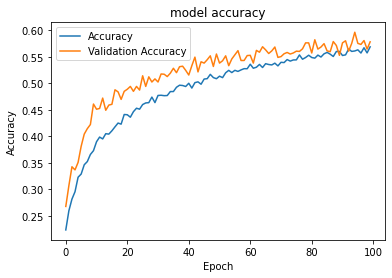

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

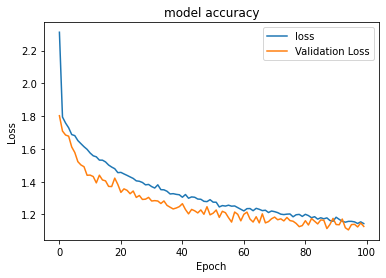

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

In [15]:
while True:
    pass

KeyboardInterrupt: 